In [2]:
from model import *
from data import *
import os
import matplotlib.pyplot as plt
from utils import plot_segm_history
import numpy as np
from keras.applications.vgg16 import VGG16

Using TensorFlow backend.


## Train your Unet with membrane data
membrane data is in folder membrane/, it is a binary classification task.

The input shape of image and mask are the same :(batch_size,rows,cols,channel = 1)

### Train with data generator

In [3]:
data_gen_args = dict(rotation_range=0.2,
                    width_shift_range=0.05,
                    height_shift_range=0.05,
                    shear_range=0.05,
                    zoom_range=0.05,
                    horizontal_flip=True,
                    fill_mode='nearest')
myGene = trainGenerator(2,'data3d/train','frames','masks',data_gen_args,save_to_dir = None)
model = unet()
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 256, 256, 64) 36928       conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 128, 128, 64) 0           conv2d_2[0][0]                   
____________________________________________________________________________________________

/home/asli/Desktop/unet_mice_segmentation-master/unet_3channel/model.py:55: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("co...)`
  model = Model(input = inputs, output = conv10)


In [4]:
# summarize filter shapes
for layer in model.layers:
	# check for convolutional layer
	if 'conv' not in layer.name:
		continue
	# get filter weights
	filters, biases = layer.get_weights()
	print(layer.name, filters.shape)

conv2d_1 (3, 3, 3, 64)
conv2d_2 (3, 3, 64, 64)
conv2d_3 (3, 3, 64, 128)
conv2d_4 (3, 3, 128, 128)
conv2d_5 (3, 3, 128, 256)
conv2d_6 (3, 3, 256, 256)
conv2d_7 (3, 3, 256, 512)
conv2d_8 (3, 3, 512, 512)
conv2d_9 (3, 3, 512, 1024)
conv2d_10 (3, 3, 1024, 1024)
conv2d_11 (2, 2, 1024, 512)
conv2d_12 (3, 3, 1024, 512)
conv2d_13 (3, 3, 512, 512)
conv2d_14 (2, 2, 512, 256)
conv2d_15 (3, 3, 512, 256)
conv2d_16 (3, 3, 256, 256)
conv2d_17 (2, 2, 256, 128)
conv2d_18 (3, 3, 256, 128)
conv2d_19 (3, 3, 128, 128)
conv2d_20 (2, 2, 128, 64)
conv2d_21 (3, 3, 128, 64)
conv2d_22 (3, 3, 64, 64)
conv2d_23 (3, 3, 64, 2)
conv2d_24 (1, 1, 2, 1)


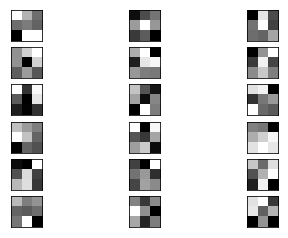

In [4]:
# retrieve weights from the second hidden layer
filters, biases = model.layers[1].get_weights()
# normalize filter values to 0-1 so we can visualize them
f_min, f_max = filters.min(), filters.max()
filters = (filters - f_min) / (f_max - f_min)
# plot first few filters
n_filters, ix = 6, 1
for i in range(n_filters):
	# get the filter
	f = filters[:, :, :, i]
	# plot each channel separately
	for j in range(3):
		# specify subplot and turn of axis
		ax = plt.subplot(n_filters, 3, ix)
		ax.set_xticks([])
		ax.set_yticks([])
		# plot filter channel in grayscale
		plt.imshow(f[:, :, j], cmap='gray')
		ix += 1
# show the figure
plt.show()

In [5]:
#now feature maps
# summarize feature map shapes
for i in range(len(model.layers)):
	layer = model.layers[i]
	# check for convolutional layer
	if 'conv' not in layer.name:
		continue
	# summarize output shape
	print(i, layer.name, layer.output.shape)

1 conv2d_1 (None, 256, 256, 64)
2 conv2d_2 (None, 256, 256, 64)
4 conv2d_3 (None, 128, 128, 128)
5 conv2d_4 (None, 128, 128, 128)
7 conv2d_5 (None, 64, 64, 256)
8 conv2d_6 (None, 64, 64, 256)
10 conv2d_7 (None, 32, 32, 512)
11 conv2d_8 (None, 32, 32, 512)
14 conv2d_9 (None, 16, 16, 1024)
15 conv2d_10 (None, 16, 16, 1024)
18 conv2d_11 (None, 32, 32, 512)
20 conv2d_12 (None, 32, 32, 512)
21 conv2d_13 (None, 32, 32, 512)
23 conv2d_14 (None, 64, 64, 256)
25 conv2d_15 (None, 64, 64, 256)
26 conv2d_16 (None, 64, 64, 256)
28 conv2d_17 (None, 128, 128, 128)
30 conv2d_18 (None, 128, 128, 128)
31 conv2d_19 (None, 128, 128, 128)
33 conv2d_20 (None, 256, 256, 64)
35 conv2d_21 (None, 256, 256, 64)
36 conv2d_22 (None, 256, 256, 64)
37 conv2d_23 (None, 256, 256, 2)
38 conv2d_24 (None, 256, 256, 1)


In [6]:
# redefine model to output right after the first hidden layer
model = Model(inputs=model.inputs, outputs=model.layers[1].output)

In [7]:
# load the image with the required shape
img = tf.keras.preprocessing.image.load_img('bird.jpg', target_size=(256, 256))
# convert the image to an array
img = tf.keras.preprocessing.image.img_to_array(img)
# expand dimensions so that it represents a single 'sample'
img = np.expand_dims(img, axis=0)
# prepare the image (e.g. scale pixel values for the vgg)
img = tf.keras.applications.vgg16.preprocess_input(img)

In [8]:
feature_maps = model.predict(img)

(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)


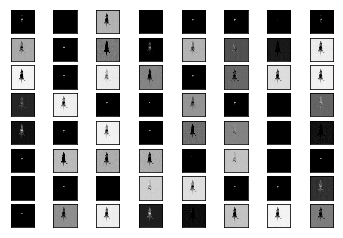

In [9]:
# plot all 64 maps in an 8x8 squares
square = 8
ix = 1
for _ in range(square):
    for _ in range(square):
        # specify subplot and turn of axis
        ax = plt.subplot(square, square, ix)
        ax.set_xticks([])
        ax.set_yticks([])
        # plot filter channel in grayscale
        print(np.shape(feature_maps[0,:,:,ix-1]))
        plt.imshow(feature_maps[0, :, :, ix-1], cmap='gray')
        ix += 1
# show the figure
plt.show()

(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)


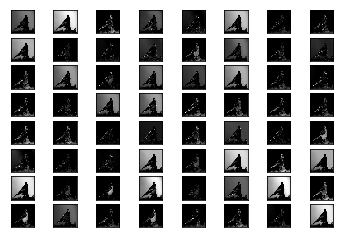

(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)


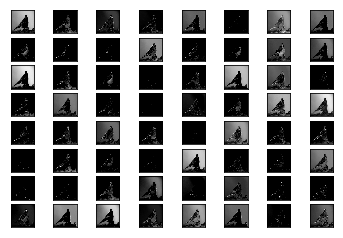

(128, 128)
(128, 128)
(128, 128)
(128, 128)
(128, 128)
(128, 128)
(128, 128)
(128, 128)
(128, 128)
(128, 128)
(128, 128)
(128, 128)
(128, 128)
(128, 128)
(128, 128)
(128, 128)
(128, 128)
(128, 128)
(128, 128)
(128, 128)
(128, 128)
(128, 128)
(128, 128)
(128, 128)
(128, 128)
(128, 128)
(128, 128)
(128, 128)
(128, 128)
(128, 128)
(128, 128)
(128, 128)
(128, 128)
(128, 128)
(128, 128)
(128, 128)
(128, 128)
(128, 128)
(128, 128)
(128, 128)
(128, 128)
(128, 128)
(128, 128)
(128, 128)
(128, 128)
(128, 128)
(128, 128)
(128, 128)
(128, 128)
(128, 128)
(128, 128)
(128, 128)
(128, 128)
(128, 128)
(128, 128)
(128, 128)
(128, 128)
(128, 128)
(128, 128)
(128, 128)
(128, 128)
(128, 128)
(128, 128)
(128, 128)


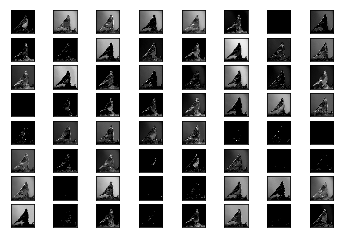

(128, 128)
(128, 128)
(128, 128)
(128, 128)
(128, 128)
(128, 128)
(128, 128)
(128, 128)
(128, 128)
(128, 128)
(128, 128)
(128, 128)
(128, 128)
(128, 128)
(128, 128)
(128, 128)
(128, 128)
(128, 128)
(128, 128)
(128, 128)
(128, 128)
(128, 128)
(128, 128)
(128, 128)
(128, 128)
(128, 128)
(128, 128)
(128, 128)
(128, 128)
(128, 128)
(128, 128)
(128, 128)
(128, 128)
(128, 128)
(128, 128)
(128, 128)
(128, 128)
(128, 128)
(128, 128)
(128, 128)
(128, 128)
(128, 128)
(128, 128)
(128, 128)
(128, 128)
(128, 128)
(128, 128)
(128, 128)
(128, 128)
(128, 128)
(128, 128)
(128, 128)
(128, 128)
(128, 128)
(128, 128)
(128, 128)
(128, 128)
(128, 128)
(128, 128)
(128, 128)
(128, 128)
(128, 128)
(128, 128)
(128, 128)


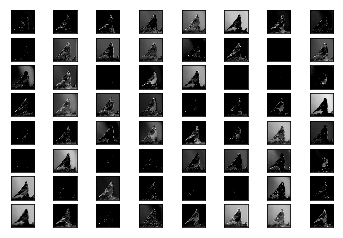

(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)


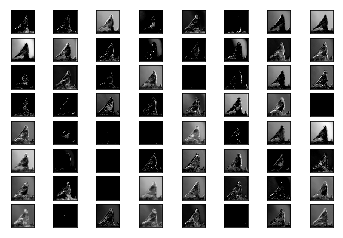

(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)


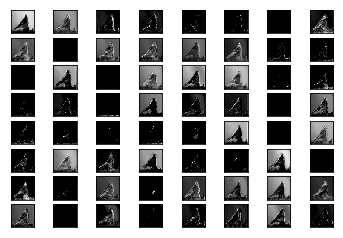

(32, 32)
(32, 32)
(32, 32)
(32, 32)
(32, 32)
(32, 32)
(32, 32)
(32, 32)
(32, 32)
(32, 32)
(32, 32)
(32, 32)
(32, 32)
(32, 32)
(32, 32)
(32, 32)
(32, 32)
(32, 32)
(32, 32)
(32, 32)
(32, 32)
(32, 32)
(32, 32)
(32, 32)
(32, 32)
(32, 32)
(32, 32)
(32, 32)
(32, 32)
(32, 32)
(32, 32)
(32, 32)
(32, 32)
(32, 32)
(32, 32)
(32, 32)
(32, 32)
(32, 32)
(32, 32)
(32, 32)
(32, 32)
(32, 32)
(32, 32)
(32, 32)
(32, 32)
(32, 32)
(32, 32)
(32, 32)
(32, 32)
(32, 32)
(32, 32)
(32, 32)
(32, 32)
(32, 32)
(32, 32)
(32, 32)
(32, 32)
(32, 32)
(32, 32)
(32, 32)
(32, 32)
(32, 32)
(32, 32)
(32, 32)


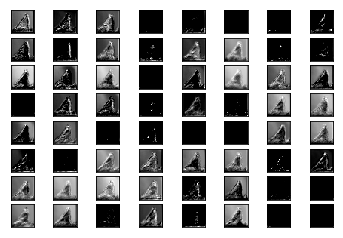

(32, 32)
(32, 32)
(32, 32)
(32, 32)
(32, 32)
(32, 32)
(32, 32)
(32, 32)
(32, 32)
(32, 32)
(32, 32)
(32, 32)
(32, 32)
(32, 32)
(32, 32)
(32, 32)
(32, 32)
(32, 32)
(32, 32)
(32, 32)
(32, 32)
(32, 32)
(32, 32)
(32, 32)
(32, 32)
(32, 32)
(32, 32)
(32, 32)
(32, 32)
(32, 32)
(32, 32)
(32, 32)
(32, 32)
(32, 32)
(32, 32)
(32, 32)
(32, 32)
(32, 32)
(32, 32)
(32, 32)
(32, 32)
(32, 32)
(32, 32)
(32, 32)
(32, 32)
(32, 32)
(32, 32)
(32, 32)
(32, 32)
(32, 32)
(32, 32)
(32, 32)
(32, 32)
(32, 32)
(32, 32)
(32, 32)
(32, 32)
(32, 32)
(32, 32)
(32, 32)
(32, 32)
(32, 32)
(32, 32)
(32, 32)


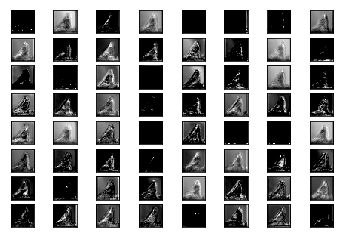

In [12]:
# redefine model to output after each block
ixs = [1,2,4,5,7,8,10,11]

model=unet()
outputs = [model.layers[i].output for i in ixs]
model = Model(inputs=model.inputs, outputs=outputs)

# load the image with the required shape
img = tf.keras.preprocessing.image.load_img('bird2.jpg', target_size=(256, 256))
# convert the image to an array
img = tf.keras.preprocessing.image.img_to_array(img)
# expand dimensions so that it represents a single 'sample'
img = np.expand_dims(img, axis=0)
# prepare the image (e.g. scale pixel values for the vgg)
img = tf.keras.applications.vgg16.preprocess_input(img)

feature_maps = model.predict(img)
# plot the output from each block
square = 8
for fmap in feature_maps:
    # plot all 64 maps in an 8x8 squares
    ix = 1
    for _ in range(square):
        for _ in range(square):
            # specify subplot and turn of axis
            ax = plt.subplot(square, square, ix)
            ax.set_xticks([])
            ax.set_yticks([])
            #print(np.shape(fmap[0,:, :, ix-1]))
            # plot filter channel in grayscale
            plt.imshow(fmap[0,:, :, ix-1], cmap='gray')
            ix += 1
    # show the figure
    plt.show()

